# Bayesian CNN on Real Data

## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf # 2.8.0
import tensorflow_probability as tfp # 0.16


# Limit GPU memory usage
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

tfpl = tfp.layers
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make default font size larger
plt.rcParams['font.size'] = 16

## Load Data and Preprocess

In [ ]:
data_path = 'data/chest_xray/'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path + 'train',
    image_size=(224, 224),
    batch_size=128,
    class_names=[
        'NORMAL',
        'PNEUMONIA'
    ],
    label_mode='categorical',
    shuffle=True)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path + 'test',
    image_size=(224, 224),
    batch_size=32,
    class_names=[
        'NORMAL',
        'PNEUMONIA'
    ],
    label_mode='categorical',
    shuffle=False)

class_names = train_ds.class_names

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
train_ds = train_ds.map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

## Explore Data

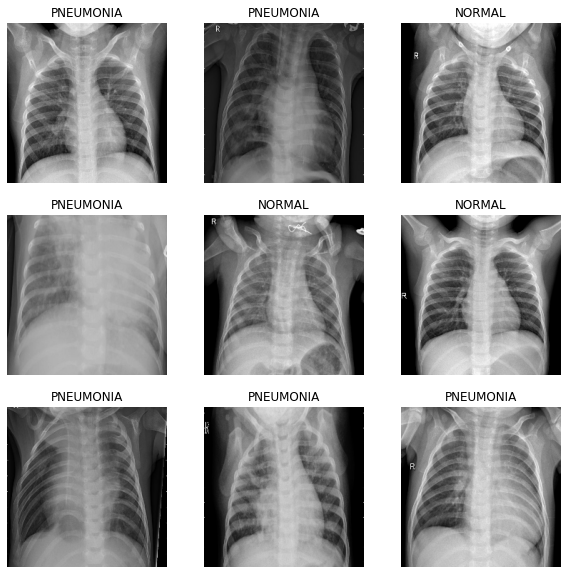

In [ ]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy())
        plt.title(class_names[np.argmax(label[i])])
        plt.axis('off')

In [ ]:
# Check the class distributions
def get_classes(dataset: tf.data.Dataset) -> np.ndarray:
    counts = []
    for image, label in dataset:
        counts.append(np.argmax(label, axis=-1))
    return np.concatenate(counts)

train_classes = get_classes(train_ds)
test_classes = get_classes(test_ds)

train_classes.shape, test_classes.shape

((5216,), (624,))

In [ ]:
class_names_train = [class_names[i] for i in train_classes]
class_names_test = [class_names[i] for i in test_classes]

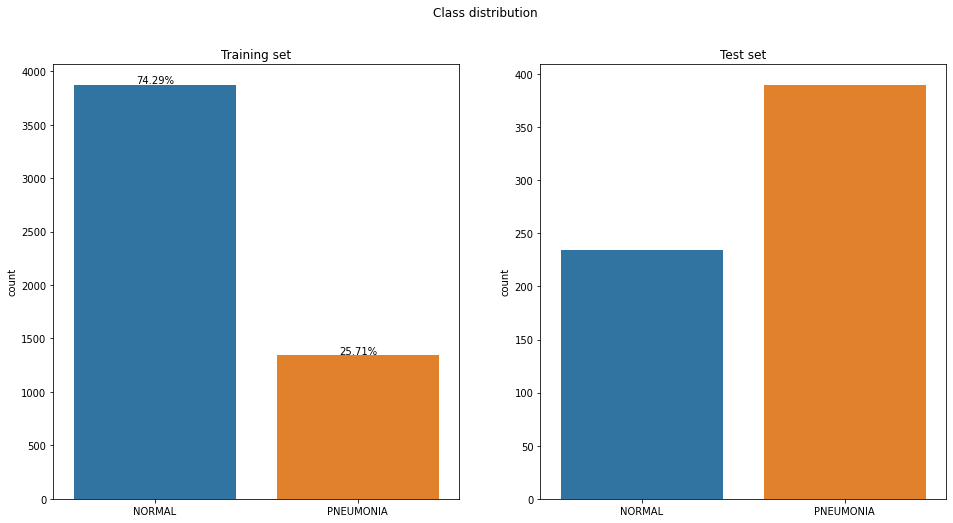

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)


sns.countplot(class_names_train, ax=ax[0])
ax[0].set_title('Training set')

# Write distribution percentages top of bars
for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x() + p.get_width() / 2.,
               height + 10,
               '{:1.2f}%'.format(height / len(train_classes) * 100),
               ha="center")


sns.countplot(class_names_test, ax=ax[1])
ax[1].set_title('Test set')
fig.suptitle('Class distribution')

plt.show()

# Custom Prior - Posterior for Reparameterization Layers

In [ ]:
def prior(dtype, shape, name, trainable, add_variable_fn):
    dist = tfd.MultivariateNormalDiag(loc=1.2 * tf.ones(shape),
                                      scale_diag=3.0*tf.ones(shape))
    
    batch_ndims = tf.size(dist.batch_shape_tensor())
    
    return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

In [ ]:
# Exponential Gaussian Posterior
# def posterior(dtype, shape, name, trainable, add_variable_fn):
#     loc_scale_fn = tfp.layers.util.default_loc_scale_fn(untransformed_scale_initializer=tf.random_normal_initializer(mean=-0.1, stddev=0.1),
#                                                         loc_initializer=tf.random_normal_initializer(mean = -0.1, stddev=0.5))
#     loc, scale = loc_scale_fn(dtype, shape, name, trainable, add_variable_fn)

#     dist = tfd.ExponentiallyModifiedGaussian(loc = loc,
#                                              scale = scale,
#                                              rate = 1.2)
#     batch_ndims = tf.size(dist.batch_shape_tensor())
#     return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

## Approximate KL Divergence

In [ ]:
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / (len(train_classes))

## Encapsulate the Creation of Reparameterization

In [ ]:
def get_convolution_reparameterization(
        filters,
        kernel_size,
        activation,
        strides = 1,
        padding = 'SAME',
        prior = prior,
        divergence_fn = divergence_fn,
        name = None) -> tfpl.Convolution2DReparameterization:
    """
    Returns a Convolution2DReparameterization layer.
    """
    return tfpl.Convolution2DReparameterization(
            filters = filters,
            kernel_size = kernel_size,
            activation = activation,
            strides = strides,
            padding = padding,
            
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_prior_fn=prior,
            kernel_divergence_fn=divergence_fn,

            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_prior_fn=prior,
            bias_divergence_fn=divergence_fn,
            name=name)

In [ ]:
def residual_block(x,
                   filters,
                   kernel_size,
                   padding,
                   activation,
                   pool_size,
                   strides,
                   name):
    # Include 3 convolutions, 2 normal & 1 residual.

    # For residual
    y = x
    
    # Conv + Act + BN
    x = get_convolution_reparameterization(
        filters = filters,
        kernel_size = kernel_size,
        activation = activation,
        strides = strides,
        padding = padding,
        name = name + 'reparam_conv1')(x)

    # Conv + Act + BN
    x = get_convolution_reparameterization(
        filters = filters,
        kernel_size = kernel_size,
        activation = activation,
        strides = strides,
        padding = padding,
            name = name + '_reparam_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name = name + '_batchnorm1')(x)

    # Residual Part
    y = get_convolution_reparameterization(
        filters = filters,
        kernel_size = (1, 1),
        activation = activation,
        strides = (1, 1),
        padding = padding,
        name = name + 'reparam_conv1_residual')(y)
    y = tf.keras.layers.BatchNormalization(name = name + 'residual_batchnorm1')(y)

    # Merge Part
    add_layer = tf.keras.layers.Add(name = name + '_merge_layer')([x, y])
    
    x = tf.keras.layers.MaxPooling2D(pool_size = pool_size,
                                     padding = padding,
                                     name = name + 'maxpool')(add_layer)

    return x

## Feature Extractor

In [ ]:
feature_extractor = tf.keras.applications.DenseNet121(include_top = False,
                                                      input_shape = (224, 224, 3),
                                                      weights = 'imagenet')
feature_extractor.summary()

## Create Bayesian ResNet

In [ ]:
x = residual_block(feature_extractor.get_layer('conv5_block9_concat').output,
                   filters = 64,
                   kernel_size = 3,
                   padding = 'same',
                   activation = tf.nn.silu,
                   pool_size = (2, 2),
                   strides = (1, 1),
                   name = 'residual_block1')
x = residual_block(x,
                   filters = 128,
                   kernel_size = 3,
                   padding = 'same',
                   activation = tf.nn.silu,
                   pool_size = (2, 2),
                   strides = (1, 1),
                   name = 'residual_block2')

x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tfpl.DenseReparameterization(units = tfpl.CategoricalMixtureOfOneHotCategorical.params_size(2, 5),
                                 activation = None,
                                 
                                 kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                 kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),

                                 bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                 bias_prior_fn=tfpl.default_multivariate_normal_fn,
                                 
                                 kernel_divergence_fn=divergence_fn,
                                 bias_divergence_fn=divergence_fn,
                                 name = 'dense_reparam')(x)

# CategoricalMixtureOfOneHotCategorical contains 5 OneHotCategorical layers.
# Event size: One sample from this layer will contain 2 classes, 
# hence event_size = 2.                                 
x = tfpl.CategoricalMixtureOfOneHotCategorical(event_size = 2,
                                               num_components = 5,
                                               convert_to_tensor_fn=tfp.distributions.Distribution.sample)(x)

model = tf.keras.Model(inputs = feature_extractor.input, outputs = x)
for layer in feature_extractor.layers:
    layer.trainable = False
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, expand_nested = True,
                          to_file = 'data/model.png')

## Train the Model

In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = nll,
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',
                                              patience = 7, restore_best_weights = True,
                                              verbose = 1),
             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                                  min_lr=1e-9,
                                                  factor = 0.1,
                                                  patience = 3,
                                                  verbose = 1)
]              

In [ ]:
model.fit(train_ds,
          epochs = 64,
          validation_data = test_ds,
          callbacks = callbacks)

In [ ]:
test_samples = []
test_labels = []
for x, y in test_ds:
    test_samples.append(x.numpy())
    test_labels.append(y.numpy())

test_samples = np.concatenate(test_samples)
test_labels = np.concatenate(test_labels)

## Inspect The Predictions

In [ ]:
def analyse_model_prediction(image, label = None, forward_passes = 10):
    if label is not None:
        label = np.argmax(label, axis = -1)
    
    # forward_passes describes the samples will be taken from the model.
    extracted_probabilities = np.empty(shape=(forward_passes, 2))
    extracted_std = np.empty(shape=(forward_passes, 2))
    
    for i in range(forward_passes):
        model_output_distribution = model(tf.expand_dims(image, 
                                                  axis = 0))
        
        # Output is a distribution, here we accept the mean as the probabilities.
        # Sample or mode can also be used. In other words, the extracted values
        # from the distribution are means.
        extracted_probabilities[i] = model_output_distribution.mean().numpy().flatten()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6),
                                   gridspec_kw={'width_ratios': [2, 4]})
    plt.xticks(fontsize = 16, rotation = 45)
    plt.yticks(fontsize = 16)

    # Show the image and the true label if provided.
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.axis('off')
    if label is not None:
        ax1.set_title('True Label: {}'.format(str(class_names[label])), fontsize = 20)
    else:
        ax1.set_title('True Label Not Given', fontsize = 20)
    
    # Obtain the 95% prediction interval.
    # extracted_probabilities.shape = (forward_passes, 2)
    # So if we sample from the model 100 times, there will be 100 different
    # values for each of the 2 classes. 
    # We get the interval for each of the classes independently.
    pct_2p5 = np.array([np.percentile(extracted_probabilities[:, i], 
                                      2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(extracted_probabilities[:, i], 
                                       97.5) for i in range(2)])   
    
    bar = ax2.bar(np.arange(2), pct_97p5, color='red')
    if label is not None:
        bar[int(label)].set_color('green')
    
    ax2.bar(np.arange(2), pct_2p5-0.02, color='white', 
            linewidth=4, edgecolor='white')
    plt.xticks(np.arange(2), labels = class_names)
    
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability', fontsize = 18)
    ax2.set_title("Model's Probabilities", fontsize = 20)
    plt.show()

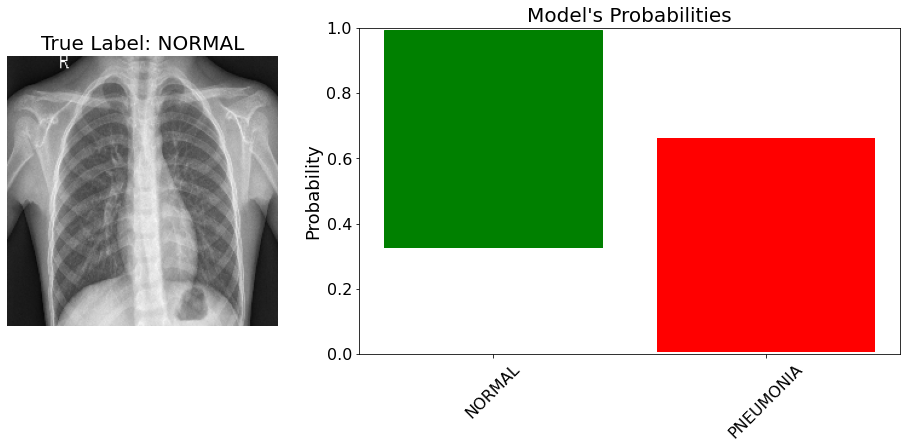

------------------------------------------------------------------------------------------


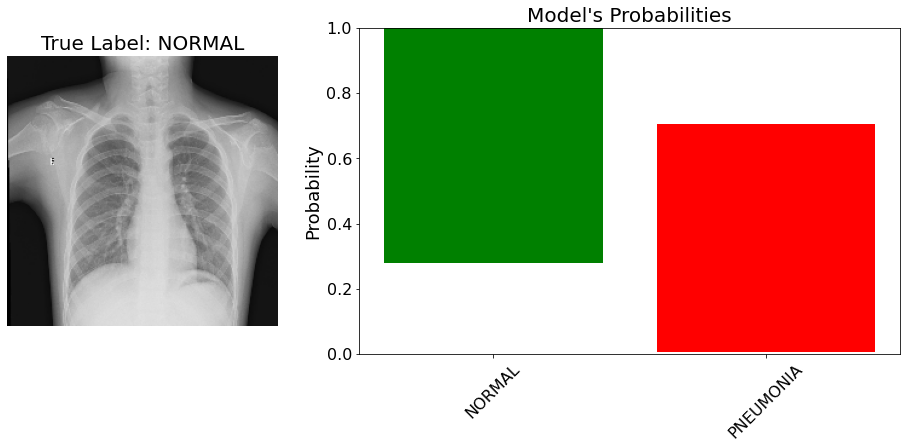

------------------------------------------------------------------------------------------


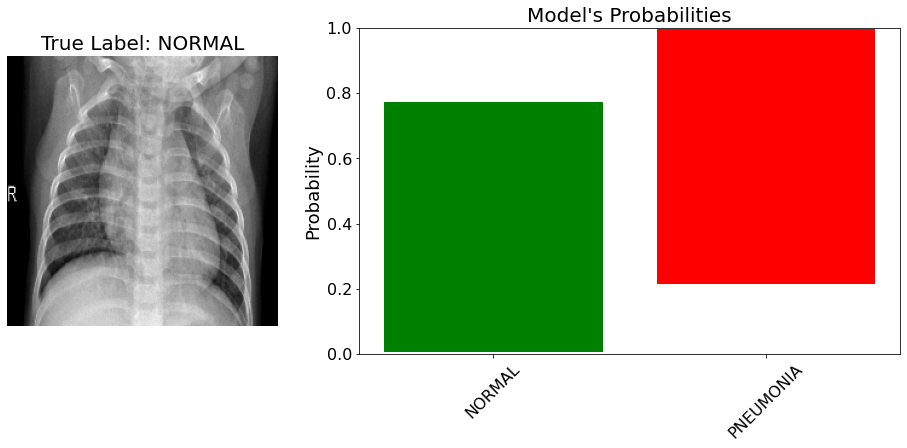

------------------------------------------------------------------------------------------


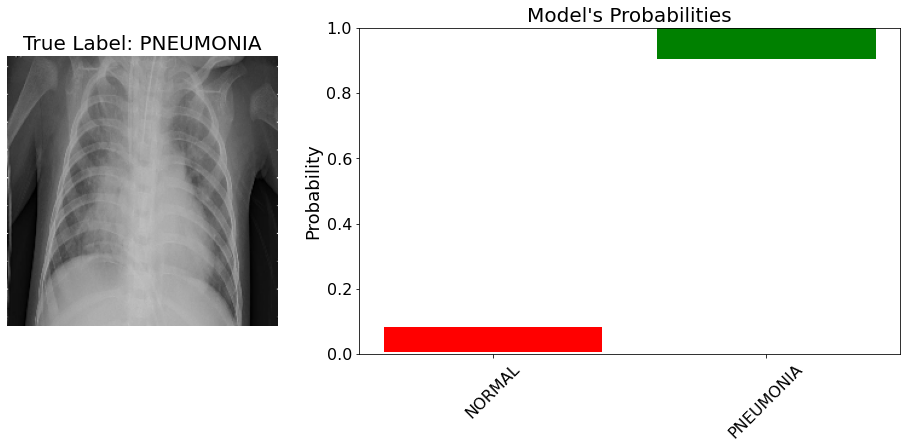

------------------------------------------------------------------------------------------


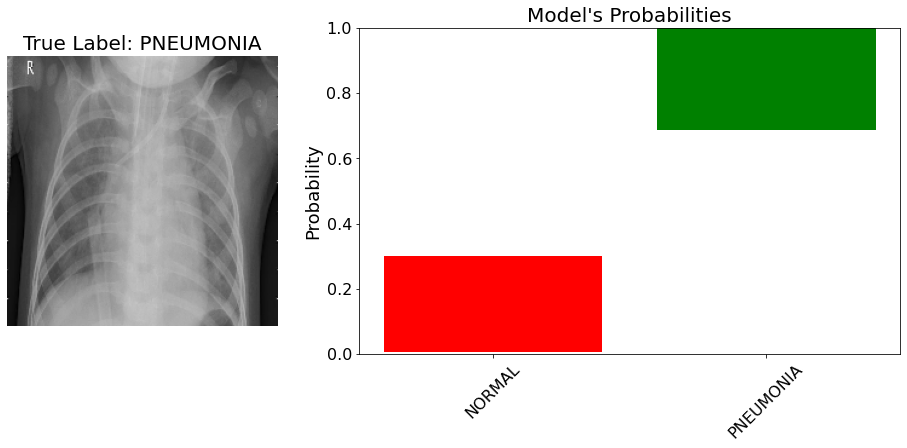

------------------------------------------------------------------------------------------


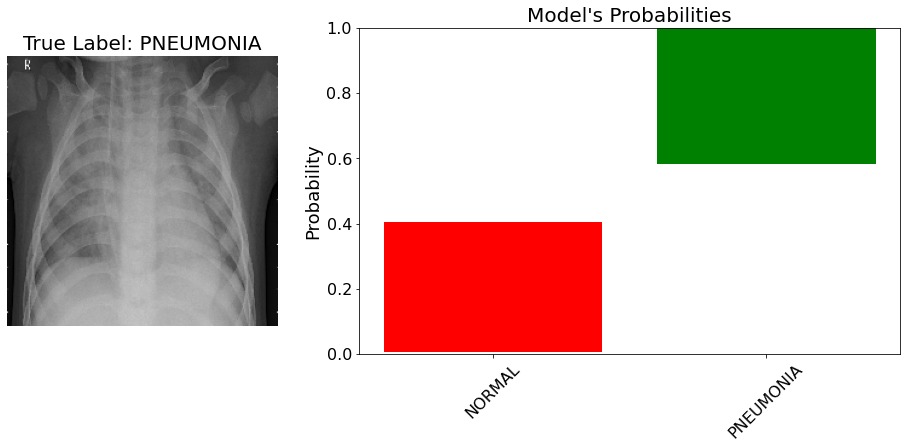

------------------------------------------------------------------------------------------


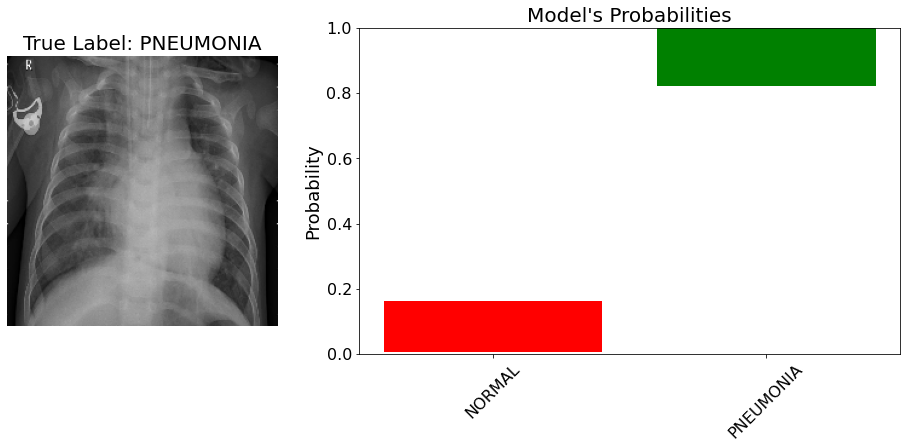

------------------------------------------------------------------------------------------


In [ ]:
for idx in range(0, 600, 95):
    analyse_model_prediction(test_samples[idx], test_labels[idx])
    print("---" * 30)